# Random Branch Class

In [147]:
import re
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from rich.progress import track

class RandomBranchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators = 4000, max_features = 14, dataset_size = None,
                 pruning_type = 'max_right', leaf_threshold = 0.8,
                 include_left = False, min_positive = 0,
                 tree_apply = 'cv', cv_size = 0.5, cv_stratify = False, cv_prec_threshold = 0,
                 criterion = 'entropy', splitter = 'best', min_samples_leaf = 1, max_depth = None,
                 min_samples_split = 2, max_leaf_nodes = None, min_weight_fraction_leaf = 0,
                 plot_trees = False, feature_names = None, remove_duplicates = 'n'):
        
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.dataset_size = dataset_size
        
        self.pruning_type = pruning_type 
        self.leaf_threshold = leaf_threshold
        
        self.include_left = include_left
        self.min_positive = min_positive
        
        self.tree_apply = tree_apply 
        self.cv_size = cv_size
        self.cv_stratify = cv_stratify
        self.cv_prec_threshold = cv_prec_threshold

        self.criterion = criterion 
        self.splitter = splitter 
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leaf_nodes = max_leaf_nodes
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        
        self.plot_trees = plot_trees
        self.feature_names = feature_names
        self.remove_duplicates = remove_duplicates

        self.features = []
        self.conditions = []
        self.conditions_a = []
        self.conditions_b = []

        self.tree_children_left = []
        self.tree_children_right = []
        self.tree_feature = []
        self.tree_threshold = []
        
        self.feature_count = []
        self.nbranches = [] 
        
    def fit(self, X, y):
        
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        if not isinstance(y, pd.Series):
            y = pd.Series(y)    
        
        if self.dataset_size != None:
            
            if self.dataset_size < 1:
                self.dataset_size = round(len(y)*self.dataset_size)
            X = X.iloc[:self.dataset_size,:]
            y = y[:self.dataset_size]
        
        if self.feature_names != None:
            self.features = self.feature_names
        else:
            self.features = X.columns 
            
        self.feature_count = [0] * len(self.features)

        for i in track(range(self.n_estimators), description="Processing..."): 
            
            random_features = np.random.choice(len(self.features), size=self.max_features, replace=False)
            selected_features = [self.features[idx] for idx in random_features]
            
            if self.cv_stratify == True:
                x_train, x_cv, y_train, y_cv = train_test_split(
                    X[selected_features], y, test_size=self.cv_size, random_state=i, stratify = y)
            else:
                x_train, x_cv, y_train, y_cv = train_test_split(
                    X[selected_features], y, test_size=self.cv_size, random_state=i)
            
            clf = tree.DecisionTreeClassifier(criterion=self.criterion, min_samples_leaf=self.min_samples_leaf,
                                              max_depth = self.max_depth,
                                              min_weight_fraction_leaf = self.min_weight_fraction_leaf,
                                              max_leaf_nodes = self.max_leaf_nodes,
                                              min_samples_split = self.min_samples_split,
                                              splitter = self.splitter)
            
            clf.fit(x_train, y_train)
            
            if self.tree_apply == 'cv':
                leave_id = clf.apply(x_cv)
                y_for_metrics = y_cv.to_list()
            else:
                leave_id = clf.apply(x_train) 
                y_for_metrics = y_train.to_list()
            
            self.tree_children_left = clf.tree_.children_left
            self.tree_children_right = clf.tree_.children_right
            self.tree_feature = clf.tree_.feature
            self.tree_threshold = clf.tree_.threshold
            
            paths = {}
            for leaf in np.unique(leave_id):
                path_leaf = []
                self.find_path(0, path_leaf, leaf)
                paths[leaf] = np.unique(np.sort(path_leaf))
                
            rules = {}
            for key in paths:
                rules[key] = self.get_rule(paths[key], selected_features)
                            
            y_pred = clf.predict(x_cv)
            cv_prec_score = precision_score(y_cv, y_pred)
                        
            df_metrics = pd.DataFrame({'leave_id': leave_id, 'y': y_for_metrics})
            df_metrics = df_metrics.groupby('leave_id').agg(positive=('y', 'sum'), total=('y', 'count')).reset_index()
            df_metrics['precision'] = df_metrics['positive'] / df_metrics['total']
            df_metrics.loc[df_metrics.positive < self.min_positive,'positive'] = 0
            df_metrics['custome_score'] = (df_metrics['precision'] > self.leaf_threshold).astype(int) * df_metrics['positive']
            
            if self.pruning_type == 'max_right' or self.pruning_type == 'max': 
                
                if cv_prec_score >= self.cv_prec_threshold and df_metrics.iloc[df_metrics['custome_score'].idxmax(), 4] != 0:
                    self.conditions.append(rules[df_metrics.iloc[df_metrics['custome_score'].idxmax(), 0].item()])
                        
            elif self.pruning_type == 'right' or self.pruning_type == 'all':  
                
                for j in range(len(rules)): 

                    leaf_ratio = df_metrics.loc[df_metrics['leave_id'] == list(rules)[j],'precision'].item()
                    leaf_positive_count = df_metrics.loc[df_metrics['leave_id'] == list(rules)[j],'positive'].item()
                    if leaf_positive_count > self.min_positive and leaf_ratio >= self.leaf_threshold and cv_prec_score >= self.cv_prec_threshold:
                        self.conditions.append(rules[list(rules)[j]]) 
            else:
                
                print("Error: please choose correct pruning type")
                return None
                
                        
            if self.plot_trees == True:
                x_size = round(clf.tree_.node_count / 2)
                plt.figure(figsize=(x_size,12)) 
                tree.plot_tree(clf, fontsize=7, feature_names=selected_features, filled = True)
                plt.show()
            
        if self.pruning_type == 'max_right' or self.pruning_type == 'right':  
            
            if self.include_left == True:
                left_conditions = [item for item in self.conditions if ">" not in item]
                self.conditions = [item for item in self.conditions if "<" not in item]
                self.conditions.extend(left_conditions)
            else:
                self.conditions = [item for item in self.conditions if "<" not in item]
        
        for string in self.conditions:
            self.feature_count = [count + res for count, res in zip(
                self.feature_count, self.count_features_in_conditions(self.features, string))] 
                
        self.conditions_a = list(set(self.conditions))
        self.conditions_b = self.remove_duplicates_from_conditions(self.conditions)
        
        if self.remove_duplicates == 'a':
            self.conditions = self.conditions_a
                
        if self.remove_duplicates == 'b':
            self.conditions = self.conditions_b
        
        self.nbranches = len(self.conditions)
        return self
    
    def predict(self, X, threshold = 0.2, remove_duplicates = 'n', exclude = 'use_feature_name'): 

        y_proba = self.predict_proba(X, remove_duplicates = remove_duplicates, exclude = exclude)
        y_pred = np.where(y_proba[:, 1] >= threshold, 1, 0)
        return y_pred

    def predict_proba(self, X, remove_duplicates = 'n', exclude = 'use_feature_name'):
        
        if remove_duplicates == 'a':
            conditions = self.conditions_a
        elif remove_duplicates == 'b': 
            conditions = self.conditions_b
        else:
            conditions = self.conditions
        
        d = 0
        predictions = np.zeros((X.shape[0], 2))
        df = X
        df['count'] = 0
        for i in range(len(conditions)):
            if (len(conditions[i]) > 0) and (exclude not in conditions[i]):
                d += 1
                df.loc[eval(conditions[i]),'count'] += 1

        predictions[:, 1] = df['count'] / d
        predictions[:, 0] = 1 - predictions[:, 1]
        
        return predictions
    
    def find_path(self, node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (self.tree_children_left[node_numb] !=-1):
            left = self.find_path(self.tree_children_left[node_numb], path, x)
        if (self.tree_children_right[node_numb] !=-1):
            right = self.find_path(self.tree_children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False
    
    def get_rule(self, path, column_names):
        mask = ''
        for index, node in enumerate(path):
            if index!=len(path)-1:
                if (self.tree_children_left[node] == path[index+1]):
                    mask += "(df['{}']<= {}) \t ".format(column_names[self.tree_feature[node]], self.tree_threshold[node])
                else:
                    mask += "(df['{}']> {}) \t ".format(column_names[self.tree_feature[node]], self.tree_threshold[node])
        mask = mask.replace("\t", "&", mask.count("\t") - 1)
        mask = mask.replace("\t", "")
        return mask
    
    def count_features_in_conditions(self, features, condition):
        feature_counts = []

        for feature in features:
            pattern = r'\b{}\b'.format(feature)  
            matches = re.findall(pattern, condition)  
            feature_counts.append(len(set(matches)))  

        return feature_counts
    
    def remove_duplicates_from_conditions(self, lst):
        pattern = r"df\['(.*?)'\]"
        extracted_lst = []
        duplicates = set()
        unique_lst = []
        
        for item in lst:
            match = re.findall(pattern, item)
            extracted_str = " ".join(match)
            extracted_lst.append(extracted_str)
            
            if extracted_str in unique_lst:
                duplicates.add(len(extracted_lst) - 1)
            else:
                unique_lst.append(extracted_str)
        
        filtered_lst = [item for i, item in enumerate(lst) if i not in duplicates]
        return filtered_lst

# Random Forest

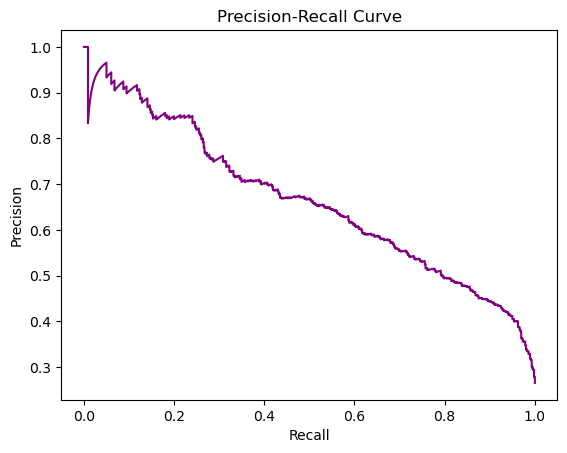

In [64]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


df = pd.read_csv("C:/WA_Fn-UseC_-Telco-Customer-Churn.csv")


def object_to_int(dataframe_series):
    if dataframe_series.dtype == 'object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series


df = df.apply(lambda x: object_to_int(x))

x = df.drop(columns=['Churn'])
y = df['Churn'].values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=40, stratify=y)

# Обучение модели Random Forest

model = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1,
                               random_state=50,
                               max_leaf_nodes=30)
model.fit(x_train, y_train)

y_pred_proba = model.predict_proba(x_test)[:, 1]

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, y_pred_proba)

fig, ax = plt.subplots()
ax.plot(recall_rf, precision_rf, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

# Add reverse features 

In [66]:
def add_rev(df):
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)
        df = df.add_prefix('ft_')

    new_df = df.apply(lambda x: x * -1)
    new_df = new_df.add_prefix('rev_')
    return pd.concat([df, new_df], axis=1)


x_train_rev = add_rev(x_train)
x_test_rev = add_rev(x_test)

# Random Branch

In [148]:
model = RandomBranchClassifier(n_estimators=10000, max_leaf_nodes=30)

model.fit(x_train_rev, pd.Series(y_train))

print("Количество условий: ", model.nbranches)
print("Количество условий без полных дубликатов: ", len(model.conditions_a))
print("Количество условий без дубликатов последовательности признаков: ", len(model.conditions_b))

Output()

Количество условий:  269
Количество условий без полных дубликатов:  241
Количество условий без дубликатов последовательности признаков:  145


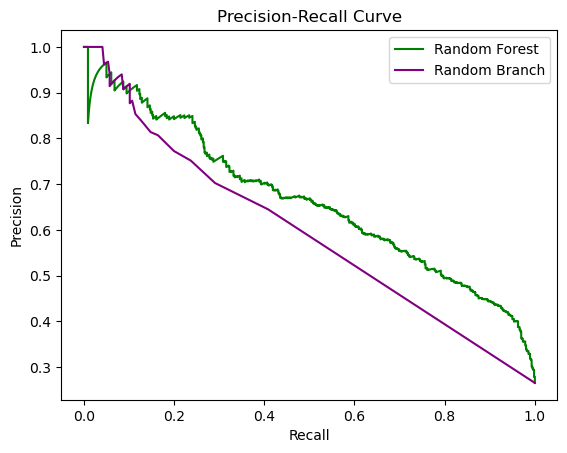

In [138]:
y_pred_proba = model.predict_proba(x_test_rev, remove_duplicates='b')[:, 1]

precision_rb, recall_rb, thresholds_rb = precision_recall_curve(
    y_test, y_pred_proba)

fig, ax = plt.subplots()
ax.plot(recall_rf, precision_rf, color='green', label="Random Forest")
ax.plot(recall_rb, precision_rb, color='purple', label="Random Branch")
ax.legend(loc="upper right")
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

# Feature frequency

In [137]:
from IPython.display import display_html 

feature_frequency = pd.DataFrame()
feature_frequency['feature'] = model.features
feature_frequency['counts'] = model.feature_count
feature_frequency['counts'] = feature_frequency['counts'] / model.nbranches

df_rev = feature_frequency[feature_frequency['feature'].str.startswith('rev_')]
df_not_rev = feature_frequency[~feature_frequency['feature'].str.startswith('rev_')]

df1_styler = df_not_rev.style.bar(
    subset=['counts'],
    align='mid',
    color=['coral', 'yellowgreen'],
    vmin=feature_frequency['counts'].min(),
    vmax=feature_frequency['counts'].max()
    ).set_table_attributes("style='display:inline'").set_caption('Direct')

df2_styler = df_rev.style.bar(
    subset=['counts'],
    align='mid',
    color=['coral', 'yellowgreen'],
    vmin=feature_frequency['counts'].min(),
    vmax=feature_frequency['counts'].max()
    ).set_table_attributes("style='display:inline'").set_caption('Reverse') 

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,feature,counts
0,customerID,0.050909
1,gender,0.000000
2,SeniorCitizen,0.000000
3,Partner,0.003636
4,Dependents,0.000000
5,tenure,0.000000
6,PhoneService,0.000000
7,MultipleLines,0.014545
8,InternetService,0.469091
9,OnlineSecurity,0.043636


# GridSearchCV

In [152]:
model_empty = RandomBranchClassifier()

params = {'n_estimators': [10000],
          'tree_apply': ['cv'],
          'cv_size': [0.3,0.5],
          'pruning_type': ['max_right'],
          'cv_stratify': [True],
          'max_leaf_nodes': [30],
          'leaf_threshold': [0.8],
          'splitter': ['best'],
          'remove_duplicates': ['b']}

def recall_prec100_score(model, X, y):
    y_proba = model.predict_proba(X)
    precision, recall, thresholds = precision_recall_curve(y, y_proba[:, 1])
    index = next((idx for idx, val in enumerate(precision) if val == 1), None)
    r_100 = recall[index]
    return r_100

scoring = {"recall_100": recall_prec100_score}

gs = GridSearchCV(model_empty, params, cv = 5, scoring=scoring, verbose = 3, refit="recall_100", n_jobs=-1)

gs.fit(x_train_rev, y_train)

gs.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Output()

{'cv_size': 0.5,
 'cv_stratify': True,
 'leaf_threshold': 0.8,
 'max_leaf_nodes': 30,
 'n_estimators': 10000,
 'pruning_type': 'max_right',
 'remove_duplicates': 'b',
 'splitter': 'best',
 'tree_apply': 'cv'}

In [153]:
cvres = gs.cv_results_
sorted_indices = np.argsort(cvres['mean_test_recall_100'])[::-1]  

for idx in sorted_indices:
    score = cvres['mean_test_recall_100'][idx]
    params = cvres['params'][idx]
    print(round(score, 3), params)

0.024 {'cv_size': 0.5, 'cv_stratify': True, 'leaf_threshold': 0.8, 'max_leaf_nodes': 30, 'n_estimators': 10000, 'pruning_type': 'max_right', 'remove_duplicates': 'b', 'splitter': 'best', 'tree_apply': 'cv'}
0.022 {'cv_size': 0.3, 'cv_stratify': True, 'leaf_threshold': 0.8, 'max_leaf_nodes': 30, 'n_estimators': 10000, 'pruning_type': 'max_right', 'remove_duplicates': 'b', 'splitter': 'best', 'tree_apply': 'cv'}
